# <center>Analiza podataka</center>

Skup podataka sa kojim ćemo raditi sastavljen je od komentara sa Wikipedije koji su klasifikovani od strane ljudi u odnosu na neprikladnost njihovog sadržaja. 

Definisano je nekoliko klasa neprikladnih komentara:
 - toksičan (toxic)
 - izuzetno toksičan (severe_toxic)
 - neopristojan (obscene)
 - preteći (threat)
 - uvredljiv (insult)
 - mržnja prema indentitetu (indentity_hate)
 
Naš zadatak je da napravimo model koji za dati komentar predviđa verovatnoću pripadnosti svakoj od navedenih klasa. 

Najpre učitavamo biblioteke neophodne za dalji rad, a zatim i skup podataka sa kojim ćemo raditi:

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from IPython.core.display import display

import nltk
from nltk.corpus import stopwords
import string
from collections import Counter
import re

Koristeći _pandas_ biblioteku, podaci zadati u formatu .csv (comma-separated values) učitavaju se u dataframe-ove. Oni su u startu podeljeni na trening i test podatke pa će na taj način i biti korišćeni.

In [2]:
train_data = pd.read_csv('data/train.csv')
x_test = pd.read_csv('data/test.csv')
y_test = pd.read_csv('data/test_labels.csv')

Proveravamo da li u skupu za obučavanje imamo nedostajuće podatke:

In [3]:
null_data = pd.DataFrame([train_data.isnull().sum(), x_test.isnull().sum()], index = ["train_data", "test_data"], dtype = "int64")
null_data = null_data.fillna("/")
null_data

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
train_data,0,0,0.0,0.0,0.0,0.0,0.0,0.0
test_data,0,0,/,/,/,/,/,/


Dakle, ne postoje instance kod kojih je neka od vrednosti Null, NA ili NaN.

Da bi se stekao uvid u to na koji način su podaci zadati, prikazuju se dimenzije odgovarajućih skupova podataka, a potom i 10 nasumično odabranih redova iz trening skupa.

In [4]:
train_data.shape

(159571, 8)

In [5]:
x_test.shape, y_test.shape

((153164, 2), (153164, 7))

In [6]:
train_data.sample(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
137848,e1a5941dee54f21f,"Check links. \n\nI have repaired link 2, I hav...",0,0,0,0,0,0
40606,6c618a8a1fd7c22d,REDIRECT User talk:Black N Red/Archive 1,0,0,0,0,0,0
31336,532f3eab522ecec8,", 31 December 2012 (UTC)\nThis is, frankly, bi...",0,0,0,0,0,0
102242,23269f6db41d7e02,Third opinion by a street-legal sock puppet ;)...,0,0,0,0,0,0
117339,7303f0f55bebc170,I didn't bring it up as a way to change the ru...,0,0,0,0,0,0
128177,ad7cc633e198c923,"""\n\n Sourcing issues \n\nI'm looking at some ...",0,0,0,0,0,0
55916,956636638d72e5ac,for being a douchebag,1,0,0,0,0,0
103724,2af1d5527eb48bc9,"""Gum!? Who would call it """"Gum?""""""",0,0,0,0,0,0
119994,81a6b4e5c020b20a,I know now: 'seven minutes!,0,0,0,0,0,0
92818,f82dfdeb14f971c2,"""\n\n Political Censorship \n\nUser: AuburnPil...",1,0,0,0,0,0


Dati skup podataka sadrže sledeće kolone:

 - id - indentifikacioni broj komentara
 - comment_text - tekst komentara
 - toxic, severe_toxic, obscene, threat, insult, identity_hate - indikatori koji daju informacije o tome kojoj klasi pripada odgovarajući komentar
 
Primetimo da komentari u podacima mogu pripadati više klasa istovremeno, kao i da svi indikatori mogu biti jednaki 0. Ukoliko su svi indikatori jednaki 0, reč je o korektnom komentaru, odnosno komentaru čiji se sadržaj ne smatra neprikladnim. 
 
Trening skup sadrži 159.571 instanci sa 2 atributa (id, comment_text) i 6 ciljnih promeljivih (toxic, severe_toxic, obscene, threat, insult, identity_hate), dok test skup sadrži 153.164 instance.

Kako kolona id ne nosi suštinsku informaciju za komentare i njihov sadržaj ona će biti obrisana i iz trening i iz test skupa.

Kako ne postoji indikator regularnosti komentara, dodajemo novu kolonu pod nazivom _regular_ koja će nositi informaciju o tome da li je komentar korektan. Podaci sa novom kolonom biće sačuvani u novom dataframe-u.


In [7]:
# određujemo sve vrste čija je suma indikatora jednaka 0 (korektni komentari)
temp = train_data.iloc[:, 2:].sum(axis = 1) == 0
temp = temp.values   # kako se dobija dataframe, za dalji rad su neophodne samo vrednosti, ne i indeksi
# kreira se lista čiji su elementi 1 (tamo gde je True u temp) i 0 (tamo gde je False u temp)
# odnosno lista indikatora da li je komentar korektan ili ne
data = [1 if elem == True else 0 for elem in temp]

column_new = pd.Series(data, name = 'regular' , dtype = 'int')
train_data_new = pd.concat((train_data, column_new), axis = 1)

# izbacujemo kolonu id
train_data_new.drop(['id'], axis = 1, inplace = True)
x_test.drop(['id'], axis = 1, inplace = True)
y_test.drop(['id'], axis = 1, inplace = True)

Prelazimo na analizu učitanih podataka. Za početak ćemo odrediti raspodelu dužine komentara izraženog u broju reči na trening skupu.

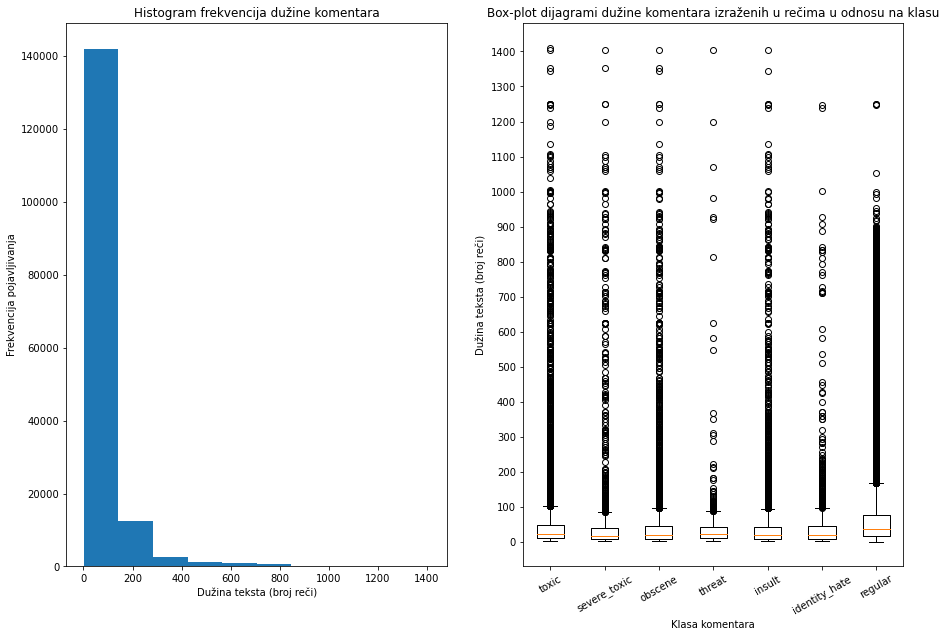

In [8]:
comment_length = [len(comment.split()) for comment in train_data_new["comment_text"]]

plt.figure(figsize = (15, 10))
plt.subplot(1, 2, 1)
plt.hist(comment_length)
plt.title('Histogram frekvencija dužine komentara')
plt.xlabel('Dužina teksta (broj reči)')
plt.ylabel('Frekvencija pojavljivanja')

# računamo dužine komentara u zavisnosti od toga kojoj klasi pripadaju
comment_length_toxic = [len(comment.split()) for comment in train_data_new[train_data_new['toxic'] == 1]['comment_text']]
comment_length_severe_toxic = [len(comment.split()) for comment in train_data_new[train_data_new['severe_toxic'] == 1]['comment_text']]
comment_length_obscene = [len(comment.split()) for comment in train_data_new[train_data_new['obscene'] == 1]['comment_text']]
comment_length_threat = [len(comment.split()) for comment in train_data_new[train_data_new['threat'] == 1]['comment_text']]
comment_length_insult = [len(comment.split()) for comment in train_data_new[train_data_new['insult'] == 1]['comment_text']]
comment_length_identity_hate = [len(comment.split()) for comment in train_data_new[train_data_new['identity_hate'] == 1]['comment_text']]
comment_length_regular = [len(comment.split()) for comment in train_data_new[train_data_new['regular'] == 1]['comment_text']]


plt.subplot(1, 2, 2)
# iscrtavamo 7 boxplotova pri čemu svaki od njih odgovara podacima dužine komentara za različite klase
plt.boxplot([comment_length_toxic, comment_length_severe_toxic, comment_length_obscene, 
             comment_length_threat, comment_length_insult, comment_length_identity_hate, comment_length_regular])
plt.title('Box-plot dijagrami dužine komentara izraženih u rečima u odnosu na klasu')
plt.xlabel('Klasa komentara')
plt.ylabel('Dužina teksta (broj reči)')

# određuju se podeoci na x i y osi kao i njihova gustina
plt.xticks(range(1, 8), ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'regular'], rotation = 30)
plt.yticks(range(0, 1401, 100))

plt.show()

Ne primećuju se značajna odstupanja strukture teksta u odnosu na klasu kojoj pripada komentar. Korisno je prikazati još neka obeležja teksta i njihove sumarne statistike koje mogu biti od koristi.

In [9]:
info = pd.DataFrame()

stop_words = set(stopwords.words("english"))
punctuation  = set(string.punctuation)

info['Broj slova'] = train_data_new['comment_text'].apply(lambda x: len(str(x)))
info['Broj reči'] = train_data_new['comment_text'].apply(lambda x: len(str(x).split()))
info['Broj jedinstvenih reči'] = train_data_new['comment_text'].apply(lambda x: len(set(str(x).split())))
info['Broj rečenica'] = train_data_new['comment_text'].apply(lambda x: len(re.findall("\n", str(x))) + 1)
info["Broj znakova interpukcije"] = train_data_new['comment_text'].apply(lambda x: len([char for char in str(x) if char in punctuation]))
info["Broj velikih slova"] = train_data_new['comment_text'].apply(lambda x: len([word for word in str(x).split() if word.isupper()]))
info["Broj početnih velikih slova"] = train_data_new['comment_text'].apply(lambda x: len([word for word in str(x).split() if word.istitle()]))
info["Broj stopwords"] = train_data_new['comment_text'].apply(lambda x: len([word for word in str(x).lower().split() if word in stop_words]))
info["Prosečna dužina komentara"] = train_data_new['comment_text'].apply(lambda x: np.mean([len(word) for word in str(x).split()]))

# ispisujemo sumarne statistike za svaki od posmatranih obeležja teksta
info.describe().iloc[1:, :]

,Broj slova,Broj reči,Broj jedinstvenih reči,Broj rečenica,Broj znakova interpukcije,Broj velikih slova,Broj početnih velikih slova,Broj stopwords,Prosečna dužina komentara
mean,394.073221,67.273527,48.097323,3.52074,15.885418,2.974206,8.510776,30.200262,4.936961
std,590.720282,99.230702,54.436443,5.96225,36.649770,21.207633,15.684382,45.296447,7.220133
min,6.000000,1.000000,1.000000,1.00000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,96.000000,17.000000,16.000000,1.00000,4.000000,0.000000,2.000000,7.000000,4.330472
50%,205.000000,36.000000,31.000000,2.00000,8.000000,1.000000,5.000000,16.000000,4.696429
75%,435.000000,75.000000,59.000000,3.00000,17.000000,3.000000,9.000000,35.000000,5.105263
max,5000.000000,1411.000000,816.000000,313.00000,4942.000000,1352.000000,1000.000000,902.000000,1655.000000


Kako postoji više klasa po kojima se komentari smatraju neprikladnim, crtamo grafik koji nam daje broj pojavljivanja komentara u odnosu na svaku klasu.

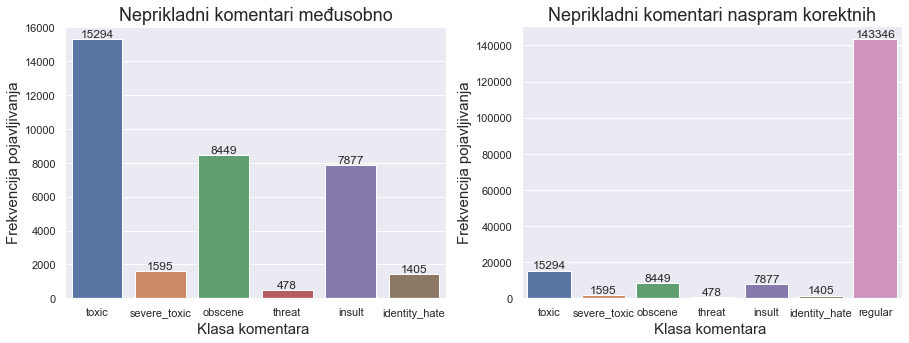

In [19]:
plt.figure(figsize = (15, 5))

# kreira se prvi od dva plot-a
plt.subplot(1, 2, 1)
x1 = train_data.iloc[:,2:].sum()
sns.set(font_scale = 1)
ax = sns.barplot(x=x1.index, y=x1.values)
plt.title('Neprikladni komentari međusobno', fontsize=18)
plt.ylabel('Frekvencija pojavljivanja', fontsize=15)
plt.xlabel('Klasa komentara ', fontsize=15)

rects = ax.patches
labels = x1.values
for rect, label in zip(rects, labels):
    ax.text(rect.get_x() + rect.get_width()/2, rect.get_height() + 10, label, ha='center', va='bottom')
    

# kreira se drugi od dva plot-a
plt.subplot(1, 2, 2)
x2 = train_data_new.iloc[:,1:].sum()
sns.set(font_scale = 1)
ax = sns.barplot(x=x2.index, y=x2.values)

plt.title('Neprikladni komentari naspram korektnih', fontsize=18)
plt.ylabel('Frekvencija pojavljivanja', fontsize=15)
plt.xlabel('Klasa komentara ', fontsize=15)

rects = ax.patches
labels = x2.values
for rect, label in zip(rects, labels):
    ax.text(rect.get_x() + rect.get_width()/2, rect.get_height() + 10, label, ha='center', va='bottom')

plt.show()

Primetimo da se najveći broj komentara smatra toksičnim, kao i da značajnu frekvenciju imaju nepristojne i uvredljive poruke. Znatno nižu frekvenciju pojavljivanja imaju izuzetno toksične, preteće i poruke mržnje identiteta.

Kako se iz rapodele neprikladnih komentara naspram korektnih uviđa nebalansiranost podataka, prikazaćemo još neke grafike na kojima je to uočljivije s obzirom da se neprikladni komentari mogu naći u više klasa istovremeno.

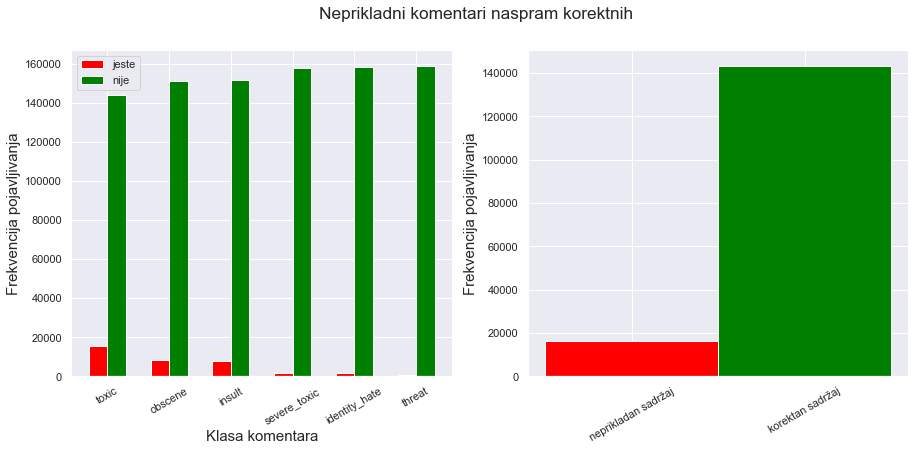

In [11]:
bar_width = 0.3   # širina stubića (bar-ova)

# kreiraju se dve liste pri čemu se u prvoj nalaze brojevi neprikladnih komentara po klasama 
# druga lista predstavlja sve one komentare koji ne pripadaju datoj klasi
negative_comment = [sum(train_data_new['toxic'] == 1), sum(train_data_new['obscene'] == 1), 
                    sum(train_data_new['insult'] == 1), sum(train_data_new['severe_toxic'] == 1), 
                    sum(train_data_new['identity_hate'] == 1), sum(train_data_new['threat'] == 1)]
positive_comment = [sum(train_data_new['toxic'] == 0), sum(train_data_new['obscene'] == 0), 
                    sum(train_data_new['insult'] == 0), sum(train_data_new['severe_toxic'] == 0), 
                    sum(train_data_new['identity_hate'] == 0), sum(train_data_new['threat'] == 0)]

# određuju se podeoci na x osi
x_ticks_neg = np.arange(len(negative_comment))
x_ticks_pos = [x + bar_width  for x in x_ticks_neg]

plt.figure(figsize = (15, 6)).suptitle("Neprikladni komentari naspram korektnih", fontsize="x-large")


# kreira se prvi od dva plota 
plt.subplot(1, 2, 1)
plt.bar(x_ticks_neg, negative_comment, color = 'red', width = bar_width, label = 'jeste')
plt.bar(x_ticks_pos, positive_comment, color = 'green', width = bar_width, label = 'nije')
plt.xticks([x + bar_width/2 for x in range(len(negative_comment))], 
           ['toxic', 'obscene', 'insult', 'severe_toxic', 'identity_hate', 'threat'], rotation = 30)
plt.xlabel('Klasa komentara', fontsize=15)
plt.ylabel('Frekvencija pojavljivanja', fontsize=15)
plt.legend(loc = "best")

# kreira se drugi od dva plot-a
plt.subplot(1, 2, 2)

# kreiraju se dve promenljive koje sadrže brojeve korektnih i neprikladnih komentara
correct_comment = sum(train_data_new['regular'] == 1)
incorrect_comment = sum(train_data_new['regular'] == 0)

plt.bar(0, incorrect_comment, width = bar_width, color = 'red')
plt.bar(bar_width, correct_comment, width = bar_width, color = 'green')
plt.xticks([0, 0.3], ['neprikladan sadržaj', 'korektan sadržaj'], rotation = 30)
plt.ylabel('Frekvencija pojavljivanja', fontsize=15)

plt.show()

Kao što je ranije navedeno, neprikladni komentari predstavljaju jedan mali procenat (~ 10.2 %) svih posmatranih komentara i dati podaci su značajno neizbalansirani. Ovaj problem može u značajnoj meri uticati na ponašanje modela što će biti diskutovano prilikom formiranja modela. 

Kako neprikladni komentari mogu biti pripadnici više klasa istovremeno neophodno je razmatrati i raspodelu komentara u odnosu na broj klasa kojima pripadaju.

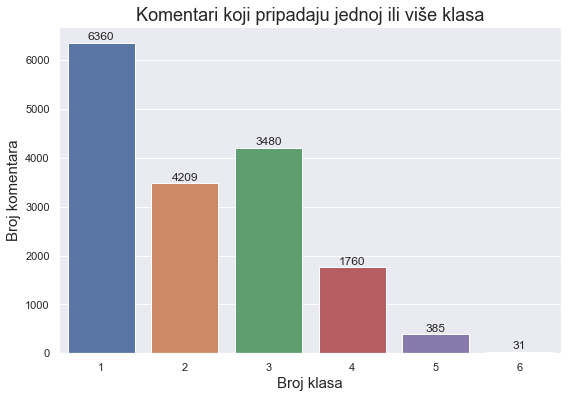

In [12]:
# sumiraju se redovi po kolonama koje predstavljaju indikatore klasa neprikladnih komentara
rowSums = train_data.iloc[:, 2:].sum(axis = 1)

# izdvaja se broj komentara u odnosu na broj klasa kojima pripada
class_number = rowSums.value_counts()
class_number = class_number.iloc[1:]

plt.figure(figsize=(9,6))
ax = sns.barplot(x=class_number.index, y=class_number.values)
plt.title("Komentari koji pripadaju jednoj ili više klasa", fontsize=18)
plt.xlabel('Broj klasa', fontsize=15)
plt.ylabel('Broj komentara', fontsize=15)

rects = ax.patches
labels = class_number.values
for rect, label in zip(rects, labels):
    ax.text(rect.get_x() + rect.get_width()/2, rect.get_height() + 10, label, ha='center', va='bottom')

plt.show()

Iako najveći broj neprikladnih komentara pripada samo jednoj klasi, značajan broj njih pripada većem broju klasa (2, 3, 4). Broj komentara koji su neprikladni po svim klasama je zanemarljivo mali. 

Kako broj pripadnika više klasa istovremeno nije zanemarljiv, neophodno je ispitati međusobne odnose klasa odnosno korelacije.

In [13]:
corr = train_data.corr()
corr

,toxic,severe_toxic,obscene,threat,insult,identity_hate
toxic,1.000000,0.308619,0.676515,0.157058,0.647518,0.266009
severe_toxic,0.308619,1.000000,0.403014,0.123601,0.375807,0.201600
obscene,0.676515,0.403014,1.000000,0.141179,0.741272,0.286867
threat,0.157058,0.123601,0.141179,1.000000,0.150022,0.115128
insult,0.647518,0.375807,0.741272,0.150022,1.000000,0.337736
identity_hate,0.266009,0.201600,0.286867,0.115128,0.337736,1.000000


Prethodno definisana matrica korelacija može se prikazati u vidu toplotne mape što olakšava uočavanje međusobnih zavisnosti

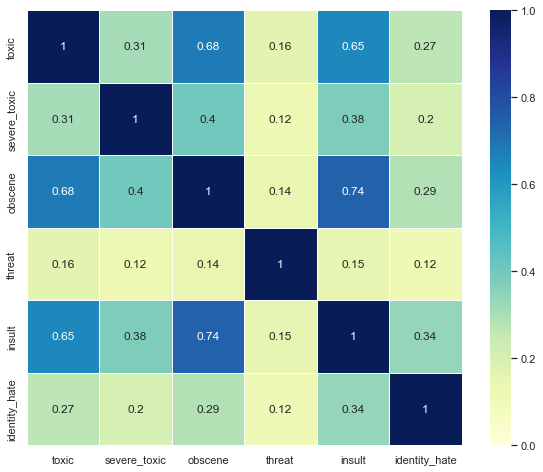

In [14]:
plt.figure(figsize = (10, 8))

colormap = plt.cm.plasma
sns.heatmap(corr, annot=True, linewidths=.5, cmap="YlGnBu", vmin=0, vmax=1, square=True)

plt.show() 

Svaka od navedenih klasa poseduje neke svoje karakteristike koje se mogu videti analizom njihovih leksika. Iz tog razloga se definišu funkcije za idvajanje najčešće korišćenih reči, ondosno reči koje na neki način karakterišu određenu klasu. Radi jednostavnosti prikaza definiše se i funkcija za prikaz ovih reči grafikom sa stubićima.

In [15]:
# definiše se funkcija za izdvajanje reči iz komentara određene klase
# za ulaze se prosleđuje trening skup i klasa od interesa

def text_extraction(train_data, klasa):
    comments = train_data[train_data[klasa] == 1]       # izdvajaju se komentari koji pripadaju određenoj klasi
    comment_text = comments.comment_text
    text = pd.Series(comment_text).str.cat(sep = ' ')   # svi komentari se sastavljaju u okviru jednog većeg tekstualnog bloka
    text = nltk.tokenize.word_tokenize(text)   # veći tekst se tokenizuje tako da se dobiju pojedinačne reči 
    stop_words = set(stopwords.words("english"))   # kreira se skup stopwords-a za engleski jezik
    punctuation  = set(string.punctuation + "0123456789")   # kreira se skup znakova interpunkcije i cifara
    # kreira se lista reči tako da njihov prvi karakter nije neki od cifara ili znakova interpunkcije
    text_no_punctuation = [word.lower() for word in text if word[0] not in punctuation]
    # kreira se lista reči tako da ne sadrže stopwords
    text_cleaned = [word.lower() for word in text_no_punctuation if word not in stop_words]
    return text_cleaned    

In [16]:
# definiše se funkcija za iscrtavanje bar plot-a najčešće korišćenih reči u okviru željene klase
# za ulaze se prosleđuje tekst i broj najčešćih reči koje treba da se izdvoje

def word_plotter(text, n):
    counter = Counter(text)   # kreira se brojač za zadati tekst
    counted_words = counter.most_common(n)   # izdvaja se n najčešćih reči
    words = [item[0] for item in counted_words]   # reči koje se najčešće pojavljuju smeštaju se u listu
    number_words = [item[1] for item in counted_words]   # broj pojavljivanja za odabrane reči
    
    plt.figure(figsize = (10, 8))
    plt.barh(words, number_words)
    plt.xlabel("Broj pojavljivanja")
    plt.ylabel("Najčešće korišćene reči")

U nastavku je prikazano po 30 najfrekventnijih reči u korektnim i toksičnim komentarima redom.

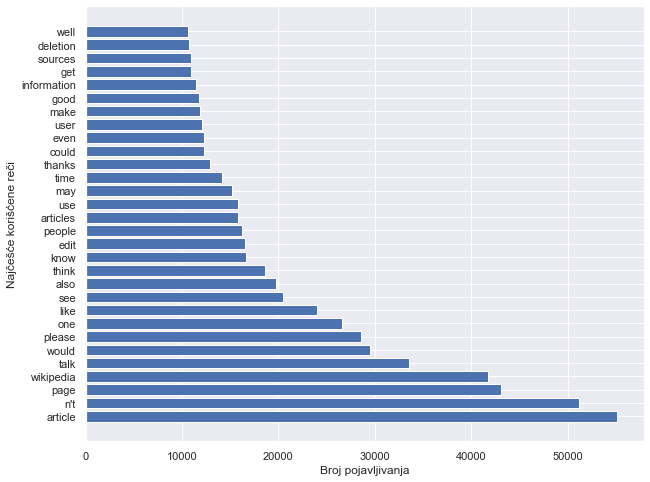

In [17]:
# izdvajaju se najčešće korišćene reči u okviru korektnih komentara korišćenjem definisanih funkcija
text = text_extraction(train_data_new, klasa = "regular")
word_plotter(text, 30)

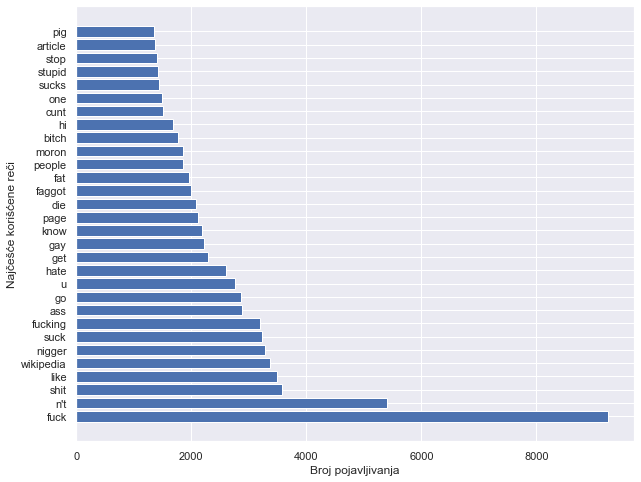

In [18]:
# izdvajaju se najčešće korišćene reči u okviru toksičnih komentara korišćenjem definisanih funkcija
text = text_extraction(train_data_new, klasa = "toxic")
word_plotter(text, 30)